In [2]:
!pip install kagglehub
!pip install emoji
!pip install spacy
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 115.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:

import os
import numpy as np
import pandas as pd
import pickle
import re
import string
import emoji
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Kaggle
import kagglehub

In [4]:
print("All packages imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

All packages imported successfully!
TensorFlow version: 2.18.0


In [5]:

# Constants
MAX_LEN = 150
VOCAB_SIZE = 20000
LABEL_COLS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Slang dictionary
SLANG_DICT = {
    # Common informal
    "u": "you", "ur": "your", "r": "are", "ya": "you", "gonna": "going_to",
    "wanna": "want_to", "gotta": "got_to", "lemme": "let_me", "kinda": "kind_of",
    "ain't": "is_not", "y'all": "you_all", "nah": "no", "thx": "thanks",
    "pls": "please", "plz": "please",

    # Emotions/reactions
    "lol": "laugh", "lmao": "laugh", "rofl": "laugh", "omg": "oh_my_god",
    "wtf": "what_the_fuck", "smh": "shaking_my_head", "tbh": "to_be_honest",
    "idk": "i_do_not_know", "ikr": "i_know_right", "bruh": "bro", "af": "very",
    "fml": "fuck_my_life", "ffs": "for_fucks_sake",

    # Toxic/hateful
    "fu": "fuck_you", "fck": "fuck", "f*ck": "fuck", "f---": "fuck",
    "stfu": "shut_the_fuck_up", "kys": "kill_yourself", "bitch": "bitch",
    "biatch": "bitch", "a**hole": "asshole", "d*ck": "dick", "nigga": "nigger",
    "n1gga": "nigger", "ni99a": "nigger", "retard": "retard", "r3tard": "retard",
    "re**rd": "retard", "sucka": "sucker",

    # Abbreviated hate
    "h8": "hate", "h8r": "hater", "killurself": "kill_yourself", "go2hell": "go_to_hell",
    "gtfo": "get_the_fuck_out", "gtf": "get_the_fuck_out", "die": "die",
    "idiot": "idiot", "moron": "moron", "loser": "loser",

    # Mocking
    "lulz": "laugh", "noob": "novice", "n00b": "novice", "scrub": "bad_player",
    "simp": "obsessed_fan", "trash": "trash", "cringe": "cringe",

    # Threats
    "bomb": "bomb", "shoot": "shoot", "stab": "stab", "burn": "burn", "rape": "rape"
}

# Emoji dictionary
EMOJI_KEEP_DICT = {
    "☠": "skull", "😂": "laugh", "⚔": "violence",
    "😜": "sarcasm_face", "😉": "wink"
}

# Important stopwords to keep
IMPORTANT_STOPWORDS = {"not", "no", "never", "n't"}

print("Configuration set up successfully!")

Configuration set up successfully!


In [6]:
try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model loaded successfully!")
except OSError:
    print("spaCy model not found. Installing...")
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")


spaCy model loaded successfully!


In [7]:
def replace_slang(text, slang_map=SLANG_DICT):
    """Replace slang words with their full forms."""
    for slang, correct in slang_map.items():
        text = re.sub(r'\b' + re.escape(slang) + r'\b', correct, text)
    return text

def smart_emoji_handler(text, emoji_keep_dict=EMOJI_KEEP_DICT):
    """Handle emojis by converting important ones to text."""
    cleaned = ''
    for char in text:
        if char in emoji_keep_dict:
            cleaned += ' ' + emoji_keep_dict[char] + ' '
        elif char in emoji.EMOJI_DATA:
            continue
        else:
            cleaned += char
    return re.sub(r'\s+', ' ', cleaned).strip()

def preprocessing_text(text):
    """Main preprocessing function."""
    # Convert emojis
    text = smart_emoji_handler(text)

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove wiki formatting
    text = re.sub(r'\{\{.*?}}', '', text)
    text = re.sub(r'\[\[.*?]]', '', text)

    # Replace slang
    text = replace_slang(text, SLANG_DICT)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Keep only letters and some punctuation
    text = re.sub(r'[^a-zA-Z\s!?]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # spaCy processing
    if nlp is not None:
        doc = nlp(text)
        tokens = []

        for token in doc:
            word = token.text.lower()
            if word in IMPORTANT_STOPWORDS or (not token.is_stop and len(word) > 2):
                tokens.append(token.lemma_)

        return " ".join(tokens)
    else:
        words = text.split()
        return " ".join([word for word in words if len(word) > 2])

def create_tokenizer(texts, vocab_size=VOCAB_SIZE):
    """Create and fit a tokenizer."""
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts)
    return tokenizer

def texts_to_sequences(texts, tokenizer, max_len=MAX_LEN):
    """Convert texts to padded sequences."""
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

print("Preprocessing functions defined successfully!")

Preprocessing functions defined successfully!


In [8]:
print("Downloading Kaggle dataset...")
try:
    path = kagglehub.dataset_download("julian3833/jigsaw-toxic-comment-classification-challenge")
    print(f"Dataset downloaded to: {path}")
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("Please upload the dataset manually or check your Kaggle API setup")

# Load the data
print("Loading data...")
try:
    train_df = pd.read_csv(f"{path}/train.csv")
    test_df = pd.read_csv(f"{path}/test.csv")

    print(f"Training data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
    print(f"Label columns: {LABEL_COLS}")

    # Display label distribution
    print("\nLabel distribution:")
    print(train_df[LABEL_COLS].sum().sort_values(ascending=False))

    # Show sample data
    print("\nSample training data:")
    print(train_df.head())

except Exception as e:
    print(f"Error loading data: {e}")

100%|██████████| 53.4M/53.4M [00:00<00:00, 85.9MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/julian3833/jigsaw-toxic-comment-classification-challenge/versions/1
Loading data...
Training data shape: (159571, 8)
Test data shape: (153164, 2)
Label columns: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Label distribution:
toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

Sample training data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  th

In [9]:

print("Preprocessing training data...")
tqdm.pandas()

# Sample a subset for faster training (optional - remove if you want full dataset)
# train_df = train_df.sample(n=50000, random_state=42)  # Uncomment for faster training

# Preprocess training data
train_df['clean_text'] = train_df['comment_text'].progress_apply(preprocessing_text)

print("Preprocessing test data...")
test_df['clean_text'] = test_df['comment_text'].progress_apply(preprocessing_text)

# Show preprocessing results
print("\nPreprocessing examples:")
for i in range(3):
    print(f"\nOriginal: {train_df['comment_text'].iloc[i]}")
    print(f"Cleaned:  {train_df['clean_text'].iloc[i]}")

print("Data preprocessing completed!")


Preprocessing training data...


100%|██████████| 159571/159571 [39:11<00:00, 67.86it/s]


Preprocessing test data...


100%|██████████| 153164/153164 [34:09<00:00, 74.74it/s]


Preprocessing examples:

Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Cleaned:  explanation edit username hardcore metallica fan revert vandalism closure gas vote new york doll fac remove template talk page retire

Original: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Cleaned:  daww match background colour seemingly stick thank talk january utc

Original: Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
Cleaned:  hey man not try edit war guy constantly remove relevant information talk edit instead talk page ca

In [10]:
# Save cleaned training data
train_df.to_csv("train_cleaned.csv", index=False)

# Save cleaned test data
test_df.to_csv("test_cleaned.csv", index=False)

print("✅ Cleaned files saved to 'data/train_cleaned.csv' and 'data/test_cleaned.csv'")

✅ Cleaned files saved to 'data/train_cleaned.csv' and 'data/test_cleaned.csv'


In [11]:
print("Creating tokenizer...")
tokenizer = create_tokenizer(train_df['clean_text'])
print(f"Tokenizer vocabulary size: {len(tokenizer.word_index)}")


Creating tokenizer...
Tokenizer vocabulary size: 195593


In [12]:
# Convert to sequences
print("Converting texts to sequences...")
X_train = texts_to_sequences(train_df['clean_text'], tokenizer)
X_test = texts_to_sequences(test_df['clean_text'], tokenizer)

# Prepare labels
y_train = train_df[LABEL_COLS].values

print(f"Training sequences shape: {X_train.shape}")
print(f"Test sequences shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")


Converting texts to sequences...
Training sequences shape: (159571, 150)
Test sequences shape: (153164, 150)
Training labels shape: (159571, 6)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPooling1D, Dense, SpatialDropout1D


In [18]:

def build_better_lstm_model(vocab_size=VOCAB_SIZE, max_len=MAX_LEN, embedding_dim=128, lstm_units=64):
    """Build an improved LSTM model for toxic comment classification."""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        SpatialDropout1D(0.3),
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(len(LABEL_COLS), activation='sigmoid')  # Multi-label classification
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

# Build the improved model
print("Building improved model...")
model = build_better_lstm_model()
print(model.summary())


Building improved model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [19]:

X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

print(f"Training set shape: {X_train_part.shape}")
print(f"Validation set shape: {X_val.shape}")

# Set up callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'toxic_lstm_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train the model
print("Training model...")
history = model.fit(
    X_train_part, y_train_part,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Training set shape: (143613, 150)
Validation set shape: (15958, 150)
Training model...
Epoch 1/4
1120/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6543 - loss: 0.1360
Epoch 1: val_loss improved from inf to 0.04955, saving model to toxic_lstm_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.6547 - loss: 0.1358 - val_accuracy: 0.9940 - val_loss: 0.0496
Epoch 2/4
1120/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9669 - loss: 0.0498
Epoch 2: val_loss improved from 0.04955 to 0.04853, saving model to toxic_lstm_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.9670 - loss: 0.0498 - val_accuracy: 0.9940 - val_loss: 0.0485
Epoch 3/4
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9730 - loss: 0.0460
Epoch 3: val_loss did not improve from 0.04853
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.9730 - loss: 0.0460 - val_accuracy: 0.9940 - val_loss: 0.0485
Epoch 4/4
1120/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9668 - loss: 0.0436
Epoch 4: val_loss did not improve from 0.04853
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.9668 - loss: 0.0436 - val_accuracy: 0.9940 - val_loss: 0.0502
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
Training completed!


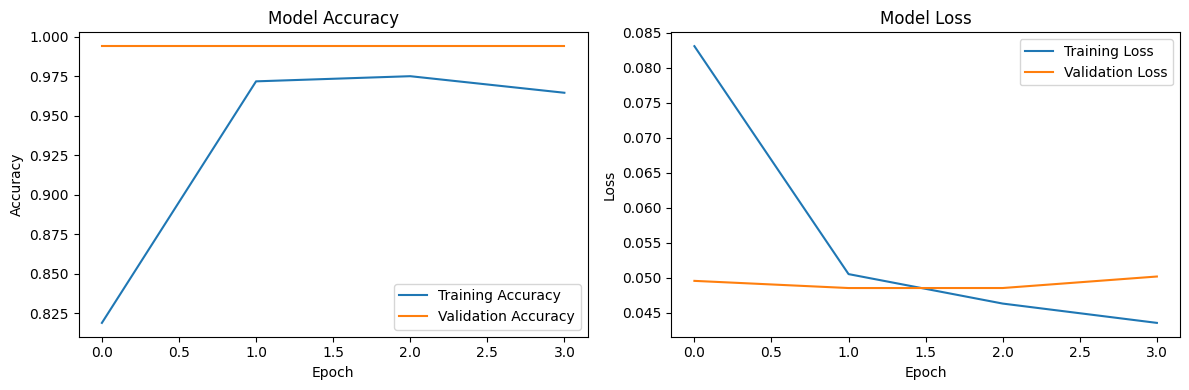

Final training accuracy: 0.9646
Final validation accuracy: 0.9940


In [20]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

In [21]:
print("Evaluating model on validation set...")
val_predictions = model.predict(X_val)
val_binary_predictions = (val_predictions >= 0.5).astype(int)

# Calculate metrics for each label
print("\nValidation Results:")
print("="*50)

for i, label in enumerate(LABEL_COLS):
    if np.sum(y_val[:, i]) > 0:
        auc = roc_auc_score(y_val[:, i], val_predictions[:, i])
        accuracy = accuracy_score(y_val[:, i], val_binary_predictions[:, i])

        print(f"{label.upper()}:")
        print(f"  AUC: {auc:.4f}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Positive examples: {np.sum(y_val[:, i])}")

Evaluating model on validation set...
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

Validation Results:
TOXIC:
  AUC: 0.9718
  Accuracy: 0.9629
  Positive examples: 1480
SEVERE_TOXIC:
  AUC: 0.9861
  Accuracy: 0.9909
  Positive examples: 148
OBSCENE:
  AUC: 0.9893
  Accuracy: 0.9802
  Positive examples: 836
THREAT:
  AUC: 0.9574
  Accuracy: 0.9977
  Positive examples: 37
INSULT:
  AUC: 0.9807
  Accuracy: 0.9709
  Positive examples: 791
IDENTITY_HATE:
  AUC: 0.9602
  Accuracy: 0.9908
  Positive examples: 147


In [22]:

def predict_toxicity(model, tokenizer, text, threshold=0.5):
    """Predict toxicity for a single text."""
    # Preprocess the text
    cleaned_text = preprocessing_text(text)

    # Convert to sequence
    sequences = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

    # Predict
    predictions = model.predict(padded)[0]
    results = {}
    positive_labels = []

    for i, label in enumerate(LABEL_COLS):
        prob = float(predictions[i])
        results[label] = prob

        if prob >= threshold:
            positive_labels.append((label, prob))

    results['positive_labels'] = positive_labels
    results['is_toxic'] = len(positive_labels) > 0

    return results

# Test sample comments
print("Testing sample comments...")
test_comments = [
    "I love this product! Absolutely fantastic experience.",
    "You're a genius, keep up the great work!",
    "This is the worst service ever, totally disappointed.",
    "You suck and nobody likes you.",
    "Go to hell, you idiot!",
    "Thank you so much for your support!",
    "I hate you so much, you stupid moron!",
    "Great job on this project, well done!",
]

for comment in test_comments:
    result = predict_toxicity(model, tokenizer, comment)
    print(f"\nComment: '{comment}'")
    print(f"Toxic: {'YES' if result['is_toxic'] else 'NO'}")

    if result['is_toxic']:
        print("Labels detected:")
        for label, prob in result['positive_labels']:
            print(f"  - {label}: {prob:.3f}")


Testing sample comments...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Comment: 'I love this product! Absolutely fantastic experience.'
Toxic: NO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Comment: 'You're a genius, keep up the great work!'
Toxic: NO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Comment: 'This is the worst service ever, totally disappointed.'
Toxic: NO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Comment: 'You suck and nobody likes you.'
Toxic: YES
Labels detected:
  - toxic: 0.990
  - obscene: 0.889
  - insult: 0.684
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Comment: 'Go to hell, you idiot!'
Toxic: YES
Labels detected:
  - toxic: 0.990
  - obscene: 0.896
  - insult: 0.715
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Comment: 'Thank you so much for your support!'
Toxic: NO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Comment: 'I hate you so much, you stupid moron!'
Toxic: YES
Labels detected:
  - toxic: 0.991
  - obscene: 0.893
  - insult: 0.740
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Comment: 'Great job o

In [23]:
# Save the tokenizer
print("Saving tokenizer...")
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Model and tokenizer saved successfully!")
print("Files created:")
print("- toxic_lstm_model.h5 (trained model)")
print("- tokenizer.pkl (fitted tokenizer)")

Saving tokenizer...
Model and tokenizer saved successfully!
Files created:
- toxic_lstm_model.h5 (trained model)
- tokenizer.pkl (fitted tokenizer)


In [24]:
from google.colab import files

print("Downloading model files...")
files.download('toxic_lstm_model.h5')
files.download('tokenizer.pkl')

print("Files downloaded successfully!")
print("You can now use these files in your local environment.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files downloaded successfully!
You can now use these files in your local environment.


In [25]:
# Test loading the saved model
print("Testing saved model...")
loaded_model = load_model('toxic_lstm_model.h5')

# Test with a sample comment
test_comment = "This is a test comment"
result = predict_toxicity(loaded_model, tokenizer, test_comment)
print(f"Test prediction for '{test_comment}': {result['is_toxic']}")

print("Model loading test successful!")


Testing saved model...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Test prediction for 'This is a test comment': False
Model loading test successful!


In [26]:

print("\n" + "="*60)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)
print("Files created:")
print("1. toxic_lstm_model.h5 - Your trained model")
print("2. tokenizer.pkl - Fitted tokenizer")
print("\nNext steps:")
print("1. Download these files from Colab")
print("2. Place them in your local 'models/' directory")
print("3. Use the Flask API code to serve predictions")
print("="*60)


TRAINING COMPLETED SUCCESSFULLY!
Files created:
1. toxic_lstm_model.h5 - Your trained model
2. tokenizer.pkl - Fitted tokenizer

Next steps:
1. Download these files from Colab
2. Place them in your local 'models/' directory
3. Use the Flask API code to serve predictions


In [27]:
model.save("model.keras")
